# SemEval 2023 Visual WSD: Binary Classification using RoBERTa-base, VIT-base

Dual encoder network baseline with pretrained transformer models:
- https://huggingface.co/roberta-base
- https://huggingface.co/google/vit-base-patch32-224-in21k

In [1]:
import transformers
import torch
import pandas as pd
from PIL import Image
from pathlib import Path
import numpy as np
from torchvision.io import read_image, ImageReadMode
from typing import *
from dataclasses import dataclass
import random
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryAccuracy

In [2]:
RANDOM_SEED = 42
DATASET_VERSION = "v1"
PART = 'train'
PATH = Path(f'/home/s1m00n/research/vwsd-train-{DATASET_VERSION}/semeval-2023-task-1-V-WSD-train-v1').resolve() / f"{PART}_{DATASET_VERSION}"
DATA_PATH = PATH / f"{PART}.data.v1.txt"
IMAGES_PATH = PATH / f"{PART}_images_{DATASET_VERSION}"
LABELS_PATH = PATH / f"{PART}.gold.v1.txt"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_encoder_name = "roberta-base"
img_encoder_name = "google/vit-base-patch16-224"
DEVICE

device(type='cuda')

In [3]:
df = pd.read_csv(DATA_PATH, sep="\t", header=None)
df.columns = ["word", "context"] + [f"image{i}" for i in range(10)]
df["label"] = pd.read_csv(LABELS_PATH, sep="\t", header=None)
df

,word,context,image0,image1,image2,image3,image4,image5,image6,image7,image8,image9,label
0,moorhen,moorhen swamphen,image.3.jpg,image.8.jpg,image.4.jpg,image.1.jpg,image.2.jpg,image.0.jpg,image.5.jpg,image.6.jpg,image.7.jpg,image.9.jpg,image.0.jpg
1,serinus,serinus genus,image.3.jpg,image.23.jpg,image.4.jpg,image.1.jpg,image.2.jpg,image.20.jpg,image.5.jpg,image.24.jpg,image.22.jpg,image.21.jpg,image.20.jpg
2,pegmatite,pegmatite igneous,image.41.jpg,image.39.jpg,image.42.jpg,image.43.jpg,image.40.jpg,image.44.jpg,image.37.jpg,image.38.jpg,image.36.jpg,image.35.jpg,image.35.jpg
3,bangalores,bangalores torpedo,image.58.jpg,image.59.jpg,image.64.jpg,image.57.jpg,image.55.jpg,image.56.jpg,image.62.jpg,image.63.jpg,image.61.jpg,image.60.jpg,image.55.jpg
4,bonxie,bonxie skua,image.3.jpg,image.77.jpg,image.78.jpg,image.4.jpg,image.1.jpg,image.2.jpg,image.5.jpg,image.79.jpg,image.76.jpg,image.75.jpg,image.75.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12864,bomarea,bomarea genus,image.11820.jpg,image.3.jpg,image.4.jpg,image.1.jpg,image.2.jpg,image.1559.jpg,image.1285.jpg,image.5.jpg,image.6482.jpg,image.10937.jpg,image.11820.jpg
12865,tragopogon,tragopogon genus,image.3.jpg,image.6250.jpg,image.15001.jpg,image.4.jpg,image.1.jpg,image.2.jpg,image.12074.jpg,image.5.jpg,image.4087.jpg,image.12806.jpg,image.12074.jpg
12866,illustrator,illustrator artist,image.10633.jpg,image.723.jpg,image.13372.jpg,image.881.jpg,image.12635.jpg,image.726.jpg,image.5985.jpg,image.722.jpg,image.724.jpg,image.725.jpg,image.10633.jpg
12867,brunfelsia,brunfelsia genus,image.3.jpg,image.8911.jpg,image.5195.jpg,image.4.jpg,image.12827.jpg,image.1.jpg,image.2.jpg,image.5.jpg,image.9129.jpg,image.8605.jpg,image.8911.jpg


In [4]:
@dataclass
class BinaryClassificationSample:
    word: str
    context: str
    image_name: Path
    label: bool

@dataclass
class BinaryClassificationItem:
    tokens: torch.Tensor
    image: torch.Tensor
    label: int

class BinaryClassificationDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data_path: Path,
        labels_path: Path,
        images_path: Path,
        text_tokenizer: Callable[[str], torch.Tensor],
        image_preprocessor: Callable[[torch.Tensor], torch.Tensor],
        negative_sampling: str = 'same',
        negative_sampling_random_state: Optional[int] = None,
        use_context_as_text: bool = True,
        enable_caching: bool = True,
    ) -> None:
        self.use_context_as_text = use_context_as_text
        self.images_path = images_path
        self.text_tokenizer = text_tokenizer
        self.image_preprocessor = image_preprocessor
        self.cache_enabled = enable_caching
        if self.cache_enabled:
            self.items_cache = dict()
        df = pd.read_csv(data_path, sep="\t", header=None)
        df.columns = ["word", "context"] + [f"image.{i}" for i in range(10)]
        df["label"] = pd.read_csv(labels_path, sep="\t", header=None)
        # Just taking positive samples directly
        self.samples = [
            BinaryClassificationSample(
                word=row["word"],
                context=row["context"],
                image_name=row["label"],
                label=True,
            ) 
            for _, row in df.iterrows()
        ]
        # Making negative samples for
        random.seed(negative_sampling_random_state)
        negative_samples = []
        if negative_sampling == 'same':
            for _, row in df.iterrows():
                other_images = filter(
                    lambda n: n != row["label"], 
                    map(lambda i: f"image.{i}.jpg",range(10))
                )
                negative_samples.append(
                    BinaryClassificationSample(
                        word=row["word"],
                        context=row["context"],
                        image_name=random.choice(list(other_images)),
                        label=False,
                    )
                )
        elif negative_sampling == 'all':
            for _, row in df.iterrows():
                other_images = filter(
                    lambda n: n != row["label"], 
                    map(lambda i: f"image.{i}.jpg",range(10))
                )
                negative_samples += [
                    BinaryClassificationSample(
                        word=row["word"],
                        context=row["context"],
                        image_name=img,
                        label=False,
                    ) for img in other_images
                ]
        else:
            raise ValueError(f"expected `negative_sampling` argument to equal 'same' or 'all', but got '{negative_sampling}'")
        self.samples += negative_samples

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        if self.cache_enabled and (idx in self.items_cache):
            return self.items_cache[idx]
        else:
            sample = self.samples[idx]
            text = sample.context if self.use_context_as_text else sample.word
            img_path = str(self.images_path / sample.image_name)
            try:
                item = BinaryClassificationItem(
                    tokens=self.text_tokenizer(text),
                    image=self.image_preprocessor(Image.open(img_path).convert("RGB")),
                    label=int(sample.label),
                )
                if self.cache_enabled:
                    self.items_cache[idx] = item
                return item 
            except Exception as e:
                # TODO: fix image loading & uncomment previous Exception raise
                print(f"Got exception \"{e}\" when tried to get at index {idx} with properties: text: \"{text}\", img_path: \"{img_path}\", label: \"{sample.label}\"; returning zeros for image tensor")

                item = BinaryClassificationItem(
                    tokens=self.text_tokenizer(text),
                    image=torch.zeros((3, 224, 224)),
                    label=0,
                )
                if self.cache_enabled:
                    self.items_cache[idx] = item
                return item
                # raise Exception(f"Got exception \"{e}\" when tried to get at index {idx} with properties: text: \"{text}\", img_path: \"{img_path}\", label: \"{sample.label}\"")

In [5]:
@dataclass
class BinaryClassificationBatch:
    text_inputs: transformers.BatchEncoding
    image_inputs: torch.Tensor 
    labels: torch.Tensor

    def to(self, device):
        return BinaryClassificationBatch(
            text_inputs=self.text_inputs.to(device),
            image_inputs=self.image_inputs.to(device),
            labels=self.labels.to(device),
        )

class Collator:
    def __init__(
        self,
        text_collator: Callable[[List[Dict[str, torch.Tensor]]], Dict[str, torch.Tensor]],
        image_collator: Callable[[torch.Tensor], torch.Tensor],
        labels_collator: Callable[[List[int]], torch.Tensor] = lambda l: torch.tensor(l, dtype=torch.float),
    ) -> None:
        self.text_collator = text_collator
        self.image_collator = image_collator
        self.labels_collator = labels_collator

    def __call__(self, items: List[BinaryClassificationItem]) -> BinaryClassificationBatch:
        return BinaryClassificationBatch(
            text_inputs=self.text_collator([item.tokens for item in items]),
            image_inputs=self.image_collator([item.image for item in items]),
            labels=self.labels_collator([item.label for item in items]),
        )

In [6]:
# see /home/s1m00n/research/transformers/src/transformers/models/vision_text_dual_encoder/modeling_vision_text_dual_encoder.py
# -> should test the built-in model
# also see /home/s1m00n/research/transformers/src/transformers/models/roberta/modeling_roberta.py
class BinaryClassificationModel(nn.Module):
    def __init__(
        self,
        text_encoder: transformers.PreTrainedModel,
        image_encoder: transformers.PreTrainedModel,
        text_dropout_rate: float = 0.0,
        image_dropout_rate: float = 0.0,
        text_projection_enable_bias: bool = True,
        image_projection_enable_bias: bool = True,
        projection_dim: int = 768,
    ):
        super().__init__()
        self.text_encoder = text_encoder
        self.text_dropout = nn.Dropout(p=text_dropout_rate)
        self.text_projection = nn.Linear(self.text_encoder.config.hidden_size, projection_dim, bias=text_projection_enable_bias)
        self.image_encoder = image_encoder
        self.image_dropout = nn.Dropout(p=image_dropout_rate)
        self.image_projection = nn.Linear(self.image_encoder.config.hidden_size, projection_dim, bias=image_projection_enable_bias)
        # TODO: check out logit_scale in VisualTextDualEncoderModel


    def forward(self, batch: BinaryClassificationBatch) -> torch.Tensor:
        text_outputs = self.text_encoder(
            input_ids=batch.text_inputs["input_ids"],
            attention_mask=batch.text_inputs["attention_mask"],
            # TODO: do we need to specify anything else here?
        )
        text_embs = self.text_projection(self.text_dropout(text_outputs.pooler_output))
        image_outputs = self.image_encoder(
            pixel_values=batch.image_inputs,
            # TODO: do we need to specify anything else here?
        )
        image_embs = self.image_projection(self.image_dropout(image_outputs.pooler_output))
        text_embs = text_embs / text_embs.norm(dim=-1, keepdim=True)
        image_embs = image_embs / image_embs.norm(dim=-1, keepdim=True)
        return torch.sigmoid(torch.sum(text_embs * image_embs, dim = 1))

In [7]:
tokenizer = transformers.AutoTokenizer.from_pretrained(text_encoder_name)
img_processor = transformers.ViTFeatureExtractor.from_pretrained(img_encoder_name)
dataset = BinaryClassificationDataset(
    data_path=DATA_PATH,
    labels_path=LABELS_PATH,
    images_path=IMAGES_PATH,
    text_tokenizer=lambda text: tokenizer(text),
    image_preprocessor=lambda img: img_processor(images=img, return_tensors="pt")["pixel_values"][0],
    negative_sampling_random_state=RANDOM_SEED
)

In [8]:
collator = Collator(
    text_collator=lambda inputs_list: tokenizer.pad(encoded_inputs=inputs_list, return_tensors="pt"),
    image_collator=torch.utils.data.default_collate,
)
train_subset, validation_subset, test_subset = random_split(dataset, [0.7, 0.15, 0.15], generator = torch.Generator().manual_seed(RANDOM_SEED))
train_dl = DataLoader(train_subset, batch_size=24, shuffle=True, collate_fn=collator)
validation_dl = DataLoader(validation_subset, batch_size=24, shuffle=True, collate_fn=collator)
test_dl = DataLoader(test_subset, batch_size=24, shuffle=True, collate_fn=collator)

In [9]:
model = BinaryClassificationModel(
    text_encoder = transformers.AutoModel.from_pretrained(text_encoder_name),
    image_encoder = transformers.AutoModel.from_pretrained(img_encoder_name),
).to(DEVICE)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. init

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
num_epochs = 50
num_training_steps = num_epochs * len(train_dl)
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=1, )
accuracy = BinaryAccuracy().to(DEVICE)
num_training_steps

37550

In [11]:
train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []
val_loss_best = np.inf
val_acc_best = 0

l_train_dl = len(train_dl)
l_val_dl = len(validation_dl)
l_test_dl = len(test_dl)

In [12]:
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0
    model.train()
    for batch in train_dl:
        batch = batch.to(DEVICE)
        outputs = model(batch)
        loss = loss_fn(outputs, batch.labels)
        train_loss += loss.item()
        train_acc += accuracy(outputs, batch.labels).item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    train_loss /= l_train_dl
    train_loss_hist.append(train_loss)
    print(f"[{epoch}] Train loss: {train_loss}")
    train_acc /= l_train_dl
    train_acc_hist.append(train_acc)
    print(f"[{epoch}] Train acc: {train_acc}")

    val_loss = 0.0
    val_acc = 0
    model.eval()
    for batch in validation_dl:
        batch = batch.to(DEVICE)
        outputs = model(batch)
        loss = loss_fn(outputs, batch.labels)
        val_loss += loss.item()
        val_acc += accuracy(outputs, batch.labels).item()
    val_loss /= l_val_dl
    val_acc /= l_val_dl
    # scheduler.step(val_acc)
    scheduler.step(val_loss)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    
    print(f"[{epoch}] Validation loss: {val_loss}")
    if (val_loss < val_loss_best):
        print(f"[{epoch}] New best loss on validation: {val_loss_best} -> {val_loss} , diff: {val_loss_best - val_loss}")
        val_loss_best = val_loss
    print(f"[{epoch}] Validation acc: {val_acc}")
    if (val_acc > val_acc_best):
        print(f"[{epoch}] New best acc on validation: {val_acc_best} -> {val_acc} , diff: {val_acc_best - val_acc}")
        val_acc_best = val_acc

  0%|          | 10/37550 [00:17<17:48:41,  1.71s/it]/home/s1m00n/miniconda3/envs/ds/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 42/37550 [01:06<16:07:57,  1.55s/it]/home/s1m00n/miniconda3/envs/ds/lib/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (148635000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
  0%|          | 155/37550 [03:56<15:08:47,  1.46s/it]/home/s1m00n/miniconda3/envs/ds/lib/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (131300000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
  1%|          | 216/37550 [05:29<16:20:20,  1.58s/it]/home/s1m00n/miniconda3/envs/ds/lib/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (104405838 pixels) excee

Got exception "image file is truncated (34 bytes not processed)" when tried to get at index 12713 with properties: text: "journalist author", img_path: "/home/s1m00n/research/vwsd-train-v1/semeval-2023-task-1-V-WSD-train-v1/train_v1/train_images_v1/image.3010.jpg", label: "True"; returning zeros for image tensor


  2%|▏         | 751/37550 [18:41<12:55:07,  1.26s/it]

[0] Train loss: 37.94932124141688
[0] Train acc: 0.5433604878369723
Got exception "image file is truncated (18 bytes not processed)" when tried to get at index 718 with properties: text: "cirrostratus cloud", img_path: "/home/s1m00n/research/vwsd-train-v1/semeval-2023-task-1-V-WSD-train-v1/train_v1/train_images_v1/image.4123.jpg", label: "True"; returning zeros for image tensor


/home/s1m00n/miniconda3/envs/ds/lib/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (141880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[0] Validation loss: 37.98438621900097
[0] New best loss on validation: inf -> 37.98438621900097 , diff: inf
[0] Validation acc: 0.5922065377235413


  4%|▍         | 1502/37550 [28:09<4:44:09,  2.11it/s] 

[1] Train loss: 37.957047058643894
[1] Train acc: 0.542949272753713
[1] Validation loss: 38.18587859965259
[1] Validation acc: 0.5480257868766785


  6%|▌         | 2253/37550 [34:56<4:38:38,  2.11it/s] 

[2] Train loss: 38.003248883944536
[2] Train acc: 0.5292224753276009
[2] Validation loss: 38.32317169852879
[2] Validation acc: 0.5035123825073242


  8%|▊         | 3004/37550 [41:43<4:32:27,  2.11it/s] 

[3] Train loss: 38.004209943205
[3] Train acc: 0.5286219698710544
[3] Validation loss: 38.37435863921361
[3] Validation acc: 0.5032535791397095


 10%|█         | 3755/37550 [48:31<4:25:50,  2.12it/s] 

[4] Train loss: 37.680512354631084
[4] Train acc: 0.609275868705681
[4] Validation loss: 36.97602290988709
[4] New best loss on validation: 37.98438621900097 -> 36.97602290988709 , diff: 1.008363309113875
[4] Validation acc: 0.9046137928962708


 12%|█▏        | 4506/37550 [55:18<4:20:25,  2.11it/s] 

[5] Train loss: 37.02454097102707
[5] Train acc: 0.7555024679427775
[5] Validation loss: 36.77979587768176
[5] New best loss on validation: 36.97602290988709 -> 36.77979587768176 , diff: 0.19622703220533566
[5] Validation acc: 0.8565145134925842


 14%|█▍        | 5257/37550 [1:02:06<4:14:34,  2.11it/s]

[6] Train loss: 37.45241055571128
[6] Train acc: 0.6508087257094453
[6] Validation loss: 36.84800953006152
[6] Validation acc: 0.8531501889228821


 16%|█▌        | 6008/37550 [1:08:53<4:09:05,  2.11it/s] 

[7] Train loss: 36.52273590047255
[7] Train acc: 0.8610055864889041
[7] Validation loss: 37.11963581298449
[7] Validation acc: 0.793256402015686


 18%|█▊        | 6759/37550 [1:15:41<4:01:56,  2.12it/s] 

[8] Train loss: 36.409402025682475
[8] Train acc: 0.8810801285402118
[8] Validation loss: 36.42644799273947
[8] New best loss on validation: 36.77979587768176 -> 36.42644799273947 , diff: 0.35334788494228775
[8] Validation acc: 0.9233213067054749


 20%|██        | 7510/37550 [1:22:28<3:57:09,  2.11it/s] 

[9] Train loss: 36.3259115739764
[9] Train acc: 0.8960927897064727
[9] Validation loss: 36.63136181327867
[9] Validation acc: 0.8782907128334045


 22%|██▏       | 8261/37550 [1:29:16<3:51:22,  2.11it/s] 

[10] Train loss: 36.38977786291455
[10] Train acc: 0.8813346902952689
[10] Validation loss: 36.63774037805403
[10] Validation acc: 0.8844647407531738


 24%|██▍       | 9012/37550 [1:36:03<3:48:01,  2.09it/s] 

[11] Train loss: 36.3634685739855
[11] Train acc: 0.8874148187561137
[11] Validation loss: 36.61114992414202
[11] Validation acc: 0.8858693242073059


 26%|██▌       | 9763/37550 [1:42:51<3:38:21,  2.12it/s] 

[12] Train loss: 36.5069682658433
[12] Train acc: 0.8588646510628346
[12] Validation loss: 36.83362286727621
[12] Validation acc: 0.8393594622612


 28%|██▊       | 10514/37550 [1:49:38<3:35:01,  2.10it/s]

[13] Train loss: 36.594244385527546
[13] Train acc: 0.841387955310659
[13] Validation loss: 36.84532998363424
[13] Validation acc: 0.839914083480835


 30%|███       | 11265/37550 [1:56:26<3:27:03,  2.12it/s] 

[14] Train loss: 36.593562856336405
[14] Train acc: 0.8413324723548483
[14] Validation loss: 36.8462967783768
[14] Validation acc: 0.8399144411087036


 32%|███▏      | 12016/37550 [2:03:13<3:21:09,  2.12it/s] 

[15] Train loss: 36.592043790296614
[15] Train acc: 0.8414760710554974
[15] Validation loss: 36.83656072912749
[15] Validation acc: 0.8398403525352478


 34%|███▍      | 12767/37550 [2:10:01<3:14:47,  2.12it/s] 

[16] Train loss: 36.58761419913423
[16] Train acc: 0.8414989154284868
[16] Validation loss: 36.85527435444897
[16] Validation acc: 0.8399882316589355


 36%|███▌      | 13518/37550 [2:16:48<3:09:32,  2.11it/s] 

[17] Train loss: 36.589411415526776
[17] Train acc: 0.8414532246983322
[17] Validation loss: 36.84107002116138
[17] Validation acc: 0.8398401737213135


 38%|███▊      | 14269/37550 [2:23:36<3:04:12,  2.11it/s] 

[18] Train loss: 36.59458877624431
[18] Train acc: 0.8415087074954087
[18] Validation loss: 36.82793543205498
[18] Validation acc: 0.8403210639953613


 40%|████      | 15020/37550 [2:30:23<2:57:58,  2.11it/s] 

[19] Train loss: 36.59584931781225
[19] Train acc: 0.8416098801496026
[19] Validation loss: 36.84713639679903
[19] Validation acc: 0.840283989906311


 42%|████▏     | 15771/37550 [2:37:11<2:51:48,  2.11it/s] 

[20] Train loss: 36.59435574192499
[20] Train acc: 0.8416098798321344
[20] Validation loss: 36.84001112280425
[20] Validation acc: 0.8402841687202454


 44%|████▍     | 16522/37550 [2:43:58<2:45:54,  2.11it/s] 

[21] Train loss: 36.591259652860316
[21] Train acc: 0.8416098795146663
[21] Validation loss: 36.83706757444773
[21] Validation acc: 0.8402469158172607


 46%|████▌     | 17273/37550 [2:50:45<2:40:15,  2.11it/s] 

[22] Train loss: 36.59443421878129
[22] Train acc: 0.8415641890226128
[22] Validation loss: 36.84548847127405
[22] Validation acc: 0.840135931968689


 48%|████▊     | 18024/37550 [2:57:32<2:33:57,  2.11it/s] 

[23] Train loss: 36.592903985481925
[23] Train acc: 0.8416327249987942
[23] Validation loss: 36.836371925306615
[23] Validation acc: 0.8403209447860718


 50%|█████     | 18775/37550 [3:04:20<2:28:08,  2.11it/s] 

[24] Train loss: 36.601446258402696
[24] Train acc: 0.8416425158752107
[24] Validation loss: 36.84222277054876
[24] Validation acc: 0.8403207659721375


 52%|█████▏    | 19526/37550 [3:11:07<2:22:46,  2.10it/s] 

[25] Train loss: 36.59244843519797
[25] Train acc: 0.8419101329522825
[25] Validation loss: 36.84137695028175
[25] Validation acc: 0.840246856212616


 54%|█████▍    | 20277/37550 [3:17:54<2:15:48,  2.12it/s] 

[26] Train loss: 36.593788065700814
[26] Train acc: 0.8419297139114451
[26] Validation loss: 36.82086847435614
[26] Validation acc: 0.8401730060577393


 56%|█████▌    | 21028/37550 [3:24:41<2:10:35,  2.11it/s] 

[27] Train loss: 36.59229911976902
[27] Train acc: 0.8419754056733711
[27] Validation loss: 36.831473936945756
[27] Validation acc: 0.8402470350265503


 58%|█████▊    | 21779/37550 [3:31:29<2:04:01,  2.12it/s] 

[28] Train loss: 36.59189291800386
[28] Train acc: 0.8419982513956001
[28] Validation loss: 36.85274455858313
[28] Validation acc: 0.8401363492012024


 60%|██████    | 22530/37550 [3:38:16<1:58:15,  2.12it/s] 

[29] Train loss: 36.59367245776993
[29] Train acc: 0.8419297144670144
[29] Validation loss: 36.83216312953404
[29] Validation acc: 0.8402470350265503


 62%|██████▏   | 23281/37550 [3:45:03<1:52:12,  2.12it/s] 

[30] Train loss: 36.59265183831023
[30] Train acc: 0.842109213973806
[30] Validation loss: 36.83244341500798
[30] Validation acc: 0.840135931968689


 64%|██████▍   | 24032/37550 [3:51:51<1:46:08,  2.12it/s] 

[31] Train loss: 36.59042743169833
[31] Train acc: 0.8421320589023646
[31] Validation loss: 36.84885032132546
[31] Validation acc: 0.8404685258865356


 66%|██████▌   | 24783/37550 [3:58:38<1:40:46,  2.11it/s] 

[32] Train loss: 36.592692922498195
[32] Train acc: 0.8422201765520119
[32] Validation loss: 36.838114708847144
[32] Validation acc: 0.840579628944397


 68%|██████▊   | 25534/37550 [4:05:25<1:35:09,  2.10it/s] 

[33] Train loss: 36.5890567401119
[33] Train acc: 0.842109213815072
[33] Validation loss: 36.83396286105517
[33] Validation acc: 0.8405056595802307


 70%|███████   | 26285/37550 [4:12:12<1:29:03,  2.11it/s] 

[34] Train loss: 36.597994937718944
[34] Train acc: 0.8421646959772122
[34] Validation loss: 36.83965932952691
[34] Validation acc: 0.8405055999755859


 72%|███████▏  | 27036/37550 [4:19:00<1:23:06,  2.11it/s] 

[35] Train loss: 36.591968429707656
[35] Train acc: 0.8420863691246144
[35] Validation loss: 36.83280746981224
[35] Validation acc: 0.8404316306114197


 74%|███████▍  | 27787/37550 [4:25:48<1:16:55,  2.12it/s] 

[36] Train loss: 36.59167540025774
[36] Train acc: 0.8421549042277584
[36] Validation loss: 36.85099400348545
[36] Validation acc: 0.8404318690299988


 76%|███████▌  | 28538/37550 [4:32:35<1:11:05,  2.11it/s] 

[37] Train loss: 36.59274600571227
[37] Train acc: 0.8421418500962492
[37] Validation loss: 36.8407430411866
[37] Validation acc: 0.8403946757316589


 78%|███████▊  | 29289/37550 [4:39:23<1:05:11,  2.11it/s] 

[38] Train loss: 36.587126373768484
[38] Train acc: 0.8421973320996555
[38] Validation loss: 36.866285620268826
[38] Validation acc: 0.8403578996658325


 80%|████████  | 30040/37550 [4:46:10<59:06,  2.12it/s]   

[39] Train loss: 36.589090457768954
[39] Train acc: 0.8422528135474925
[39] Validation loss: 36.85265118142833
[39] Validation acc: 0.8404318690299988


 80%|████████  | 30108/37550 [4:47:10<1:03:06,  1.97it/s] 

KeyboardInterrupt: 

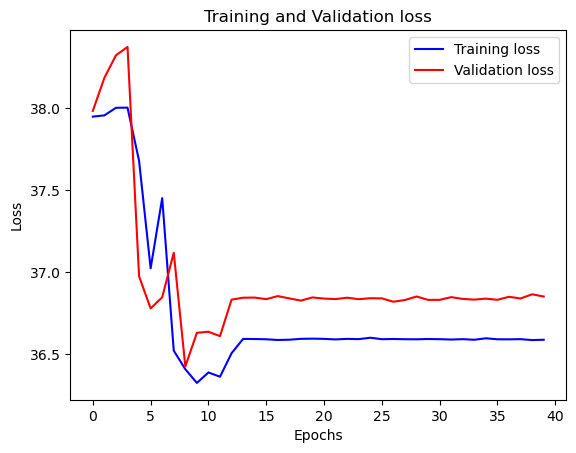

In [14]:
# epochs = range(num_epochs) # TODO: tmp
epochs = range(num_epochs - 10)
plt.plot(epochs, train_loss_hist, 'b', label='Training loss')
plt.plot(epochs, val_loss_hist, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

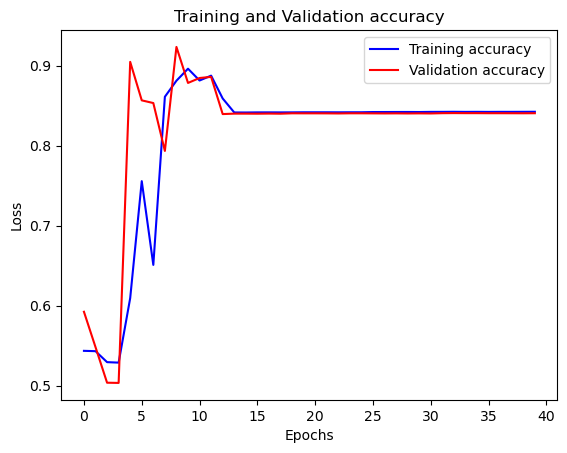

In [16]:
plt.plot(epochs, train_acc_hist, 'b', label='Training accuracy')
# plt.plot(epochs, val_acc_hist, 'r', label='Validation accuracy') # TODO: tmp
plt.plot(epochs, [x.item() for x in val_acc_hist], 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# TODO: tmp
vah = np.array([x.item() for x in val_acc_hist])
np.argmax(vah)

8

In [17]:
model.eval()
test_loss = 0.0
test_accuracy = 0.0
with torch.no_grad():
    for batch in test_dl:
        batch = batch.to(DEVICE)
        outputs = model(batch)
        loss = loss_fn(outputs, batch.labels)
        test_loss += loss.item()
        test_accuracy += accuracy(outputs, batch.labels).item()
test_loss /= len(test_dl)
print(f"Test loss: {test_loss}")
test_accuracy /= len(test_dl)
print(f"Test accuracy {test_accuracy}")

Test loss: 36.19898075790879
Test accuracy 0.8382505189557994


<mark>Do not forget to rename the path!</mark>

In [19]:
torch.save(model.state_dict(), "/home/s1m00n/research/saved_models/roberta-base_vit-base-patch32-224-in21k_binary-cls_ns-same_ep40_overfit.pth")

In [24]:
BinaryClassificationModel(
    text_encoder=None, # TODO: fix saving
    image_encoder=None,
).load_state_dict(torch.load("/home/s1m00n/research/saved_models/roberta-base_vit-base-patch32-224-in21k_binary-cls_ns-same_ep40_overfit.pth"))

AttributeError: 'NoneType' object has no attribute 'config'